In [1]:
import gin
from keychest.keychestenv import KeyChestEnvironmentRandom, KeyChestGymEnv, KeyChestEnvironment
from keychest.keychestenv_gui import jupyter_gui
from keychest.keychestenv_gofa import features_for_obs, max_reward, hardcoded_policy_step
from matplotlib import pyplot as plt
from helpers import get_env_performance
import numpy as np
from tqdm import tqdm
from time import time

In [14]:
gin.enter_interactive_mode()
gin.parse_config_file('./keychest/keychestenv_config_10x10.gin')
gin.bind_parameter('KeyChestEnvironment.flatten_observation', False)

In [17]:
env = KeyChestGymEnv()

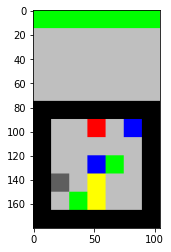

up (-1, 0) 1 -0.01 False {'event': 'initialized', 'moves': 0} -0.01


KeyboardInterrupt: Interrupted by user

In [6]:
jupyter_gui(env)

In [7]:
print("Steps per second:", get_env_performance(env, 3))

Steps per second: 6944.666666666667


In [8]:
env.reset().shape

(840,)

In [9]:
env.observation_space.shape

(840,)

In [10]:
env.action_space.shape

()

In [11]:
import gym
env1 = gym.make('CartPole-v0')
get_env_performance(env1, 3)

61008.666666666664

In [12]:
features_for_obs(env.reset())

IndexError: too many indices for array

In [18]:
mr = max_reward(env)
mr

1.56

In [ ]:
def reward_on_policy(env, policy):
    done = False
    Rmax = max_reward(env)
    obs = env.reset()
    R = 0
    while not done:
        act = policy(env)
        obs, rew, done, info = env.step(act)
        #plt.imshow(env.render(mode='rgb_array'))
        #plt.show()
        R += rew
    #print(f"Reward {R} out of {Rmax}")
    return R

In [ ]:
rews = [reward_on_policy(env, hardcoded_policy_step) for _ in tqdm(range(500))]

In [ ]:
plt.title("Rewards by hardcoded policy")
plt.hist(rews, alpha=0.5, label='Reward')
plt.axvline(mr, color='red', label='Maximal reward')
plt.legend()
plt.show()

In [ ]:
jupyter_gui(env)